# 1. INTRODUCTION
<center>
<img src="https://plus.unsplash.com/premium_photo-1661872687000-e33a6cbcd379?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=2012&q=80" width=1300 height=1000 />
</center>

**PROBLEM STATEMENT: PREDICT SOFTWARE DEFECTS**

<font size="3">Welcome to the Episode 23 of the Playground Series</font>

**Data Description**

1. loc: numeric - McCabe's line count of code
2. v(g): numeric - McCabe "cyclomatic complexity"
3. ev(g): numeric - McCabe "essential complexity"
4. iv(g): numeric - McCabe "design complexity"
5. n: numeric - Halstead total operators + operands
6. v: numeric - Halstead "volume"
7. l: numeric - Halstead "program length"
8. d: numeric - Halstead "difficulty"
9. i: numeric - Halstead "intelligence"
10. e: numeric - Halstead "effort"
11. b: numeric - Halstead 
12. t: numeric - Halstead's time estimator
13. lOCode: numeric - Halstead's line count
14. lOComment: numeric - Halstead's count of lines of comments
15. lOBlank: numeric - Halstead's count of blank lines
16. lOCodeAndComment: numeric
17. uniq_Op: numeric - unique operators
18. uniq_Opnd: numeric - unique operands
19. total_Op: numeric - total operators
20. total_Opnd: numeric - total operands
21. branchCount: numeric - percentage of the flow graph
22. defects: {false, true} - module has/has not one or more reported defects

**Objective:** Binary Classification on Defects, predict the probability of defect

**Metric of Evaluation:** ROC-AUC


# 2. IMPORTS

In [4]:
import sklearn 
import numpy as np
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
from prettytable import PrettyTable
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
tqdm_notebook.get_lock().locks = []
# !pip install sweetviz
# import sweetviz as sv
import concurrent.futures
from copy import deepcopy       
from functools import partial
from itertools import combinations
import random
from random import randint, uniform
import gc
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler,PowerTransformer, FunctionTransformer
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from itertools import combinations
from sklearn.impute import SimpleImputer
import xgboost as xg
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error,mean_squared_log_error, roc_auc_score, accuracy_score, f1_score, precision_recall_curve, log_loss
from sklearn.cluster import KMeans
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer
!pip install gap-stat
from gap_statistic.optimalK import OptimalK
from scipy import stats
import statsmodels.api as sm
from scipy.stats import ttest_ind
from scipy.stats import boxcox
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
!pip install optuna
import optuna
import xgboost as xgb
!pip install catboost
!pip install lightgbm --install-option=--gpu --install-option="--boost-root=C:/local/boost_1_69_0" --install-option="--boost-librarydir=C:/local/boost_1_69_0/lib64-msvc-14.1"
import lightgbm as lgb
!pip install category_encoders
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder, CatBoostEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier,ExtraTreesClassifier, AdaBoostClassifier
!pip install -U imbalanced-learn
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from sklearn.svm import NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from catboost import Pool
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option('display.max_columns',None)

DEPRECATION: --install-option is deprecated because it forces pip to use the 'setup.py install' command which is itself deprecated. pip 23.1 will enforce this behaviour change. A possible replacement is to use --config-settings. Discussion can be found at https://github.com/pypa/pip/issues/11358
DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453


/goinfre/sucho/miniconda3/envs/42AI-sucho/lib/python3.7/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


## 2.1 DATA

In [6]:
# train=pd.read_csv('/kaggle/input/playground-series-s3e23/train.csv')
# test=pd.read_csv('/kaggle/input/playground-series-s3e23/test.csv')
# original=pd.read_csv("/kaggle/input/software-defect-prediction/jm1.csv")

train=pd.read_csv('./playground-series-s3e23/train.csv')
test=pd.read_csv('./playground-series-s3e23/test.csv')
original=pd.read_csv("./software-defect-prediction/jm1.csv")

train.drop(columns=["id"],inplace=True)
test.drop(columns=["id"],inplace=True)

cols=['uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount']
def convert(x):
    try: 
        return float(x)
    except ValueError:
        return np.nan
for col in cols:
    original[col]=original[col].apply(convert)
original=original.dropna()
train_copy=train.copy()
test_copy=test.copy()
original_copy=original.copy()

original["original"]=1

train["original"]=0
test["original"]=0

train=pd.concat([train,original],axis=0)
train.reset_index(inplace=True,drop=True)
train.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects,original
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,0.09,302.71,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False,0
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,0.05,52.04,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False,0
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,0.07,97.45,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False,0
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,0.03,26.31,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True,0
4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,365.67,0.02,20.31,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False,0


## 2.2 MISSING VALUE CHECKS

In [7]:
table = PrettyTable()

table.field_names = ['Feature', 'Data Type', 'Train Missing %', 'Test Missing %',"Original Missing%"]
for column in train_copy.columns:
    data_type = str(train_copy[column].dtype)
    non_null_count_train= np.round(100-train_copy[column].count()/train_copy.shape[0]*100,1)
    if column!='defects':
        non_null_count_test = np.round(100-test_copy[column].count()/test_copy.shape[0]*100,1)
    else:
        non_null_count_test="NA"
    non_null_count_orig= np.round(100-original_copy[column].count()/original_copy.shape[0]*100,1)
    table.add_row([column, data_type, non_null_count_train,non_null_count_test,non_null_count_orig])
print(table)

+-------------------+-----------+-----------------+----------------+-------------------+
|      Feature      | Data Type | Train Missing % | Test Missing % | Original Missing% |
+-------------------+-----------+-----------------+----------------+-------------------+
|        loc        |  float64  |       0.0       |      0.0       |        0.0        |
|        v(g)       |  float64  |       0.0       |      0.0       |        0.0        |
|       ev(g)       |  float64  |       0.0       |      0.0       |        0.0        |
|       iv(g)       |  float64  |       0.0       |      0.0       |        0.0        |
|         n         |  float64  |       0.0       |      0.0       |        0.0        |
|         v         |  float64  |       0.0       |      0.0       |        0.0        |
|         l         |  float64  |       0.0       |      0.0       |        0.0        |
|         d         |  float64  |       0.0       |      0.0       |        0.0        |
|         i         |

<font size='3'>Awesome, there are no missing values in the dataset</font>

# 3. EXPLORATORY DATA ANALYSIS

## 3.1 TARGET DISTRIBUTIONS

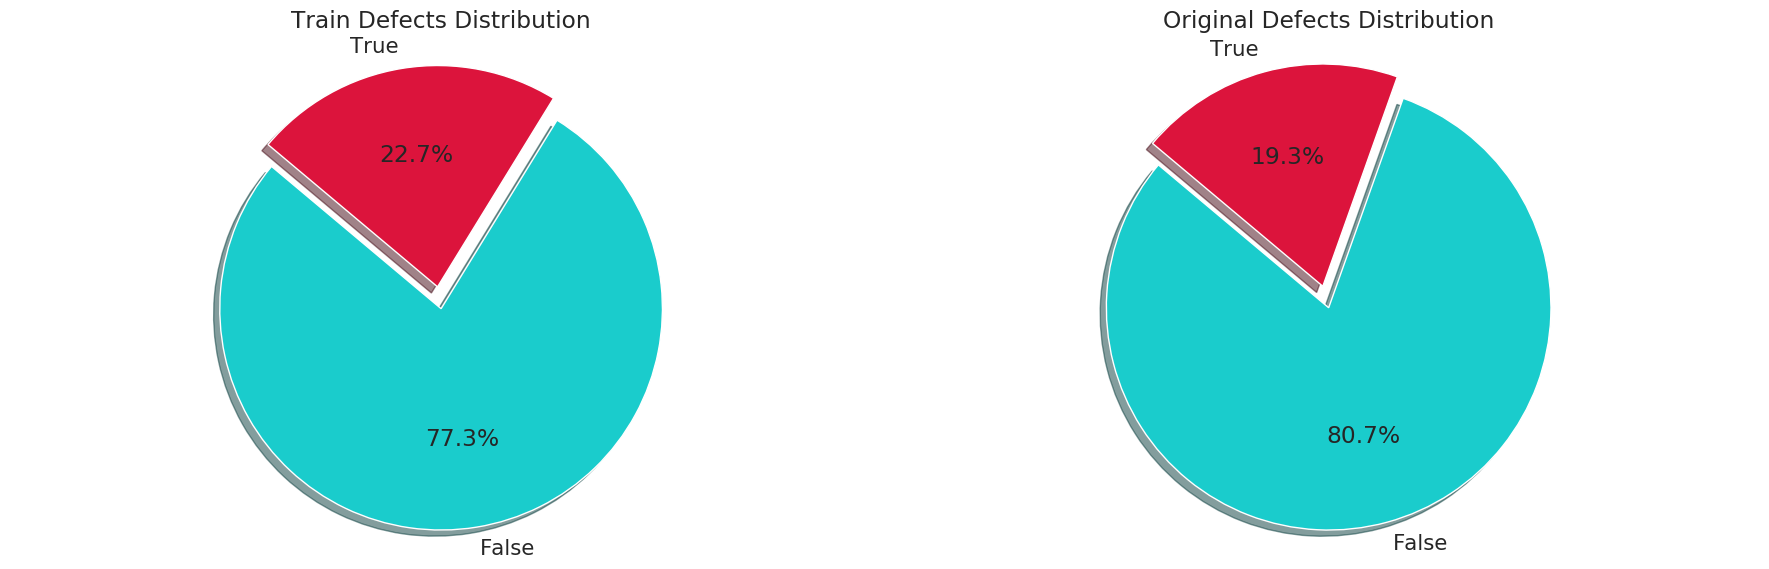

In [8]:
def plot_pie_chart(data, title, ax):
    data_counts = data['defects'].value_counts()
    labels = data_counts.index
    sizes = data_counts.values
    colors = [ (0.1, 0.8, 0.8), 'crimson']  
    explode = (0.1, 0)  

    ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    ax.axis('equal') 
    ax.set_title(title)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # Create three subplots in a row

plot_pie_chart(train_copy, "Train Defects Distribution", axes[0])
plot_pie_chart(original, "Original Defects Distribution", axes[1])

plt.tight_layout()
plt.show()


<font size="3">Both Train and the original have similar % of defects</font>

## 3.2 Numerical Feature Distributions

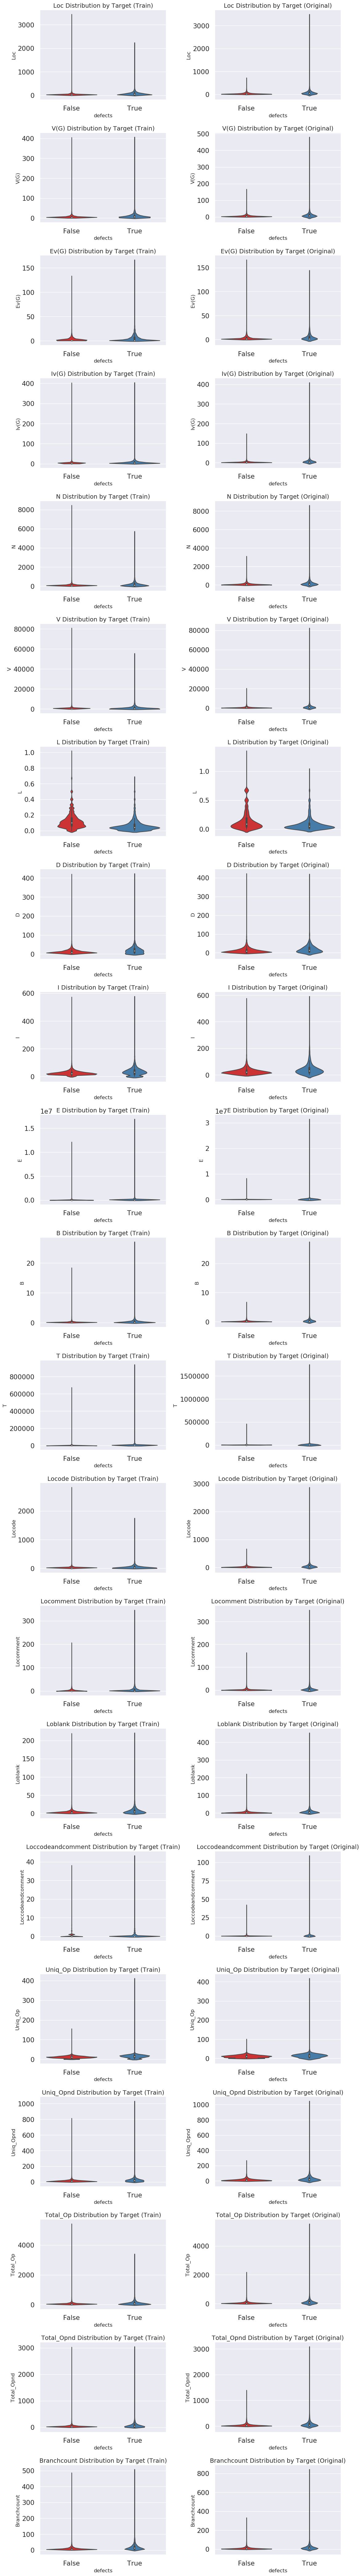

In [9]:
cont_cols = [f for f in train.columns if train[f].dtype != 'O' and train[f].nunique() > 2]
n_rows = len(cont_cols)
fig, axs = plt.subplots(n_rows, 2, figsize=(12, 4 * n_rows))
sns.set_palette("Set1")
for i, col in enumerate(cont_cols):
    sns.violinplot(x='defects', y=col, data=train_copy, ax=axs[i, 0])
    axs[i, 0].set_title(f'{col.title()} Distribution by Target (Train)', fontsize=14)
    axs[i, 0].set_xlabel('defects', fontsize=12)
    axs[i, 0].set_ylabel(col.title(), fontsize=12)
    sns.despine()

    sns.violinplot(x='defects', y=col, data=original, ax=axs[i, 1])
    axs[i, 1].set_title(f'{col.title()} Distribution by Target (Original)', fontsize=14)
    axs[i, 1].set_xlabel('defects', fontsize=12)
    axs[i, 1].set_ylabel(col.title(), fontsize=12)
    sns.despine()

fig.tight_layout()

plt.show()

1. <font size="3">All of them are skewed, both train and the original datasets have similar distributions of defects</font>
2. <font size="3">L(program length), D (difficulty), I(intelligence) seem to differentiate a bit</font>

  ## 3.3 Numerical Pair Plots - Original

<Figure size 1800x1000 with 0 Axes>

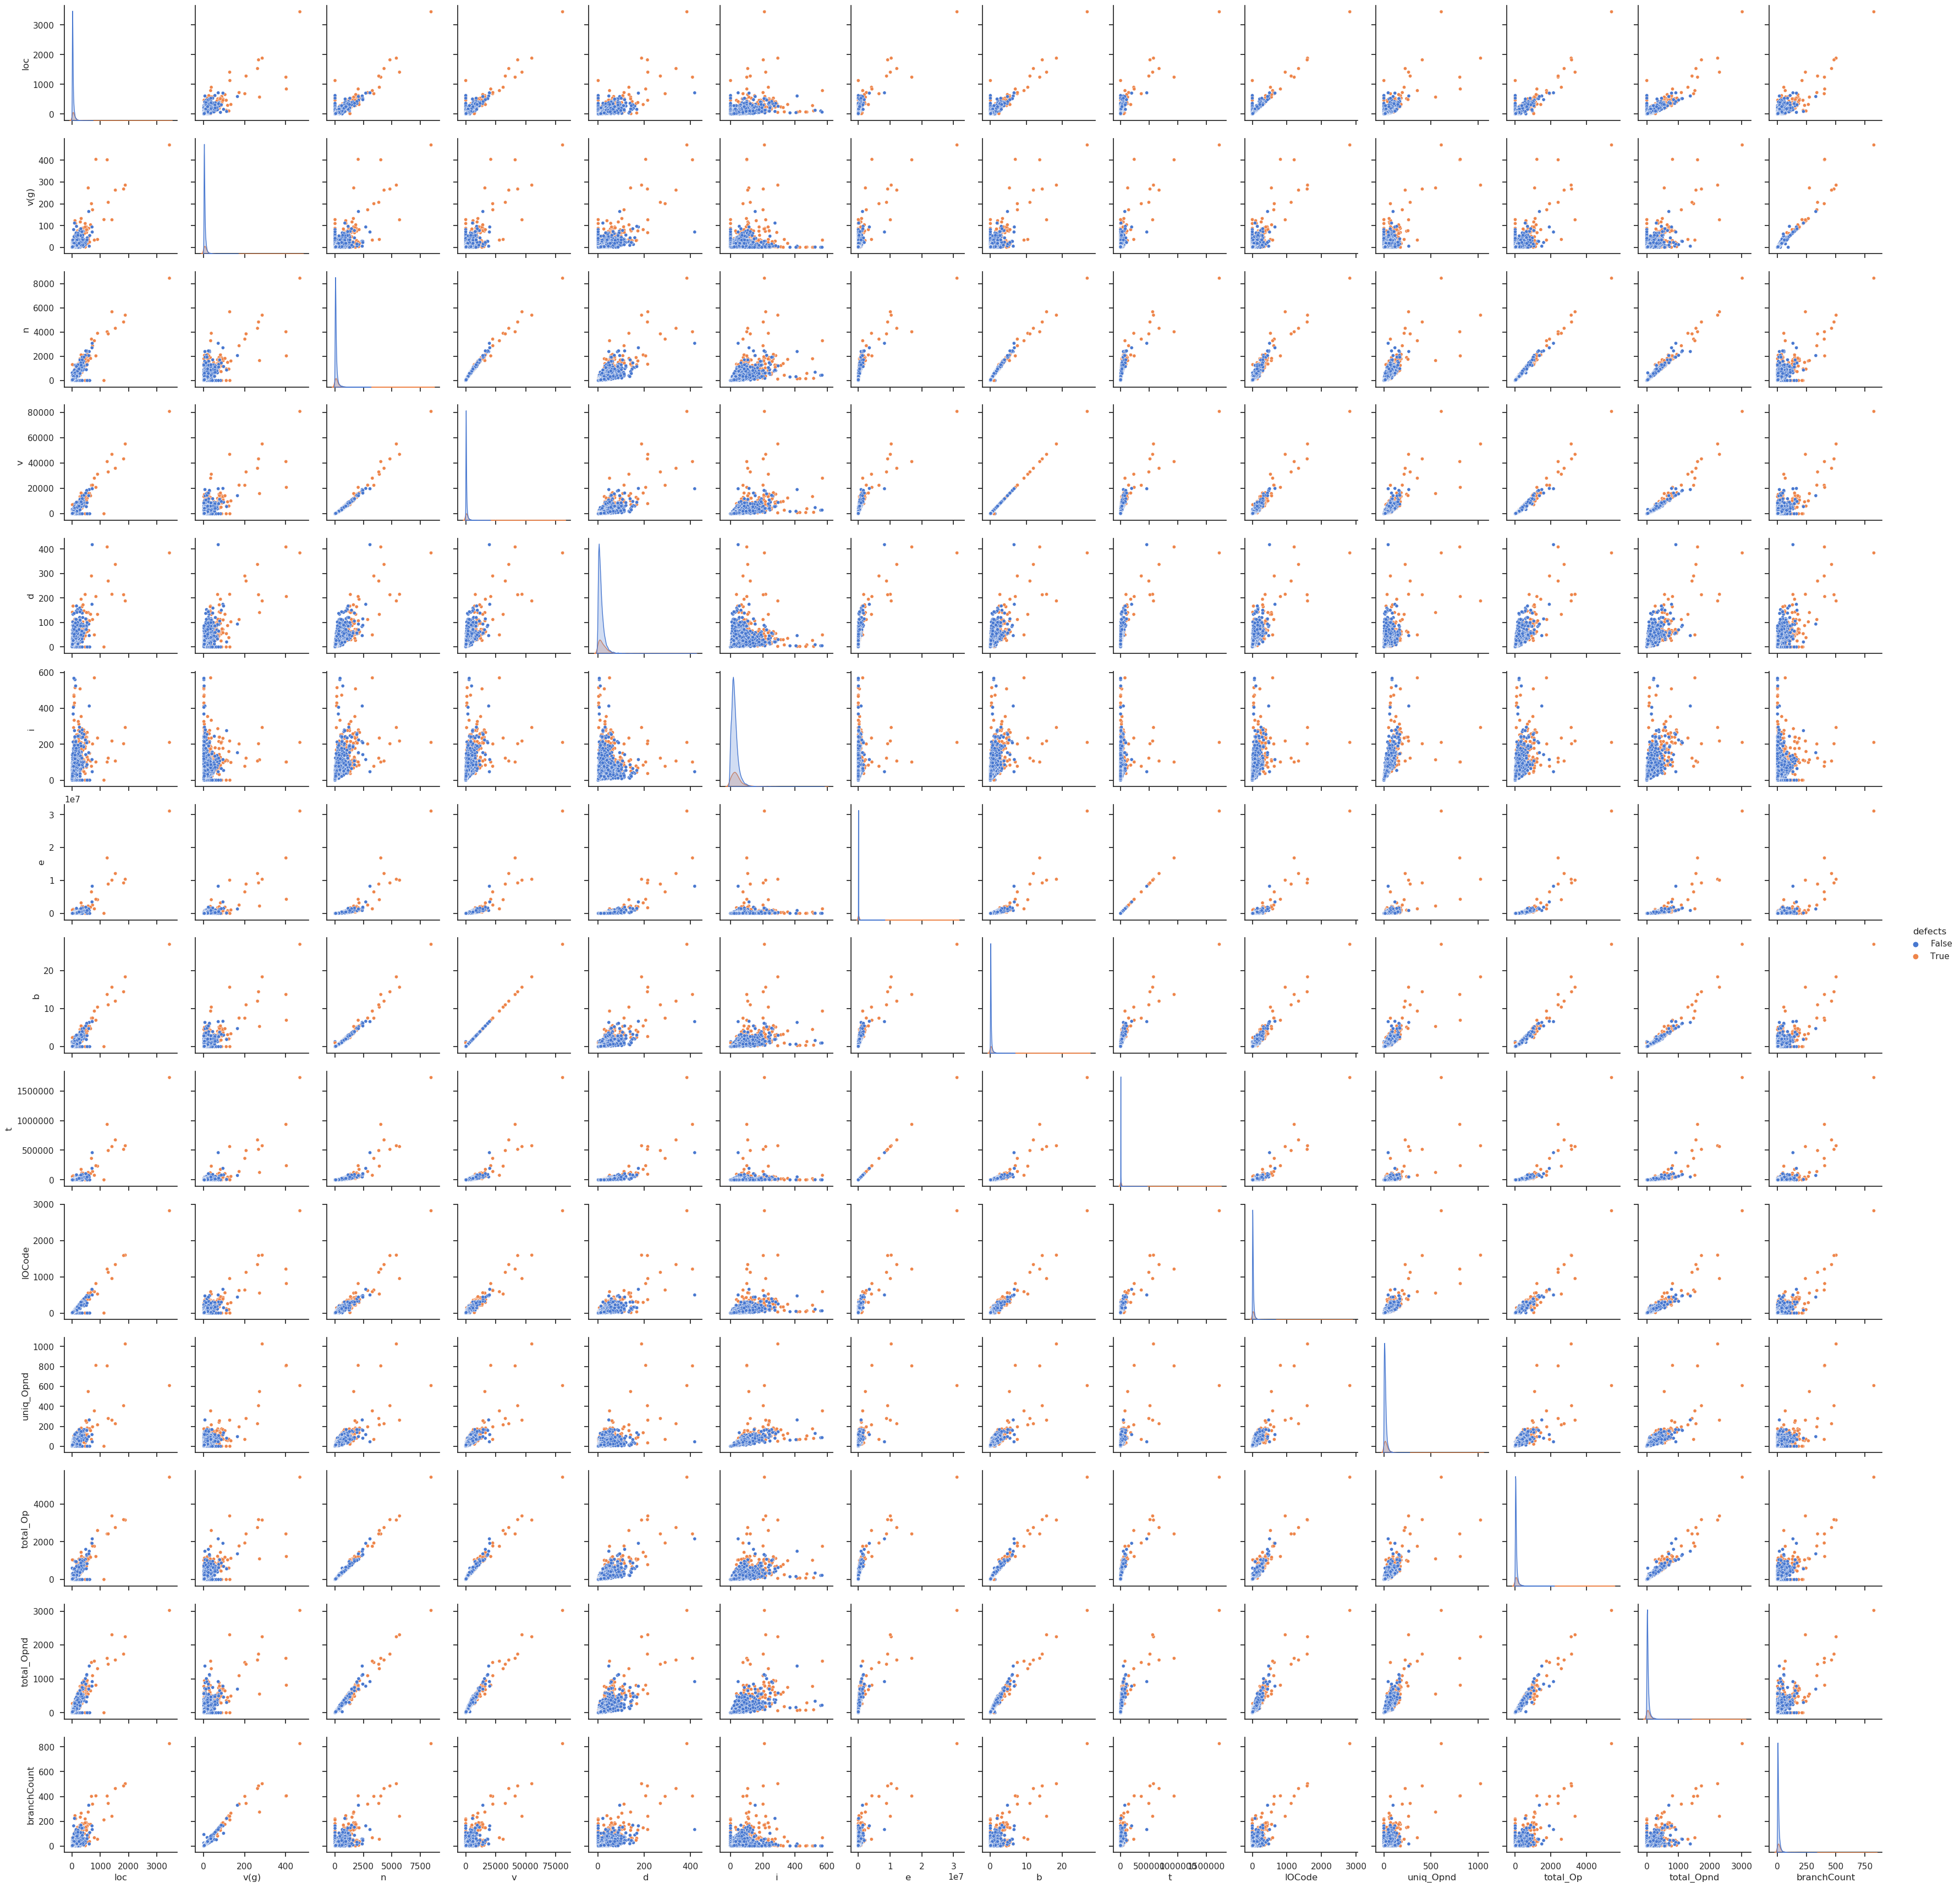

In [10]:
pair_plot_cols=[f for f in cont_cols if original[f].nunique()>100]

sns.set(font_scale=1)
plt.figure(figsize=(18, 10))
sns.set(style="ticks", color_codes=True)
sns.pairplot(data=original, vars=pair_plot_cols,diag_kind='kde', 
        kind='scatter', palette='muted', 
        plot_kws={'s': 20}, hue='defects')
plt.show()


<font size="3">We can clearly see that many features paired together distinguishes the defects and all of them have a positive effect, which is increase in both features increases the chance of defect</font>

## 3.4 SVM Bivariate Analysis

1. <font size="3">If there are many features, it would be visually difficult to plot a pair-plot and understand all the features. So here is a method that can tell us which pair of features together are really important in the classification task</font>
2. <font size="3">Let's apply SVM just using a pair of two features and the target feature, see if it's able to do the the job better</font>

In [11]:
feature_pairs = list(combinations(cont_cols, 2))
table = PrettyTable()
table.field_names = ['Feature Pair', 'ROC AUC']

for pair in feature_pairs:
    x_temp = original.loc[:, [pair[0], pair[1]]]
    y_temp = original['defects']
    model = SVC(gamma='auto')
    model.fit(x_temp, y_temp)
    y_pred = model.predict(x_temp)
    acc = accuracy_score(y_temp, y_pred)
    table.add_row([pair, acc])
table.sortby = 'ROC AUC'
table.reversesort = True
print(table)

# 4. FEATURE ENGINEENRING

### Basic Functions

In [10]:
def min_max_scaler(train, test, column):
    '''
    Min Max just based on train might have an issue if test has extreme values, 
    hence changing the denominator uding overall min and max
    '''
    sc=MinMaxScaler()
    
    max_val=max(train[column].max(),test[column].max())
    min_val=min(train[column].min(),test[column].min())

    train[column]=(train[column]-min_val)/(max_val-min_val)
    test[column]=(test[column]-min_val)/(max_val-min_val)
    
    return train,test  

def OHE(train_df,test_df,cols,target):
    '''
    Function for one hot encoding, it first combined the data so that no category is missed and
    the category with least frequency can be dropped because of redunancy
    '''
    combined = pd.concat([train_df, test_df], axis=0)
    for col in cols:
        one_hot = pd.get_dummies(combined[col])
        counts = combined[col].value_counts()
        min_count_category = counts.idxmin()
        one_hot = one_hot.drop(min_count_category, axis=1)
        one_hot.columns=[str(f)+col+"_OHE" for f in one_hot.columns]
        combined = pd.concat([combined, one_hot], axis="columns")
        combined = combined.loc[:, ~combined.columns.duplicated()]
    
    # split back to train and test dataframes
    train_ohe = combined[:len(train_df)]
    test_ohe = combined[len(train_df):]
    test_ohe.reset_index(inplace=True,drop=True)
    test_ohe.drop(columns=[target],inplace=True)
    return train_ohe, test_ohe

lgb_params = {
            'n_estimators': 100,
            'max_depth': 6,
            "num_leaves": 16,
            'learning_rate': 0.05,
            'subsample': 0.7,
            'colsample_bytree': 0.8,
            #'reg_alpha': 0.25,
            'reg_lambda': 5e-07,
            'objective': 'regression_l2',
            'metric': 'mean_squared_error',
            'boosting_type': 'gbdt',
            'random_state': 42
        }
def rmse(y1,y2):
    ''' RMSE Evaluator'''
    return(np.sqrt(mean_squared_error(np.array(y1),np.array(y2))))

def store_missing_rows(df, features):
    '''Function stores where missing values are located for given set of features'''
    missing_rows = {}
    
    for feature in features:
        missing_rows[feature] = df[df[feature].isnull()]
    
    return missing_rows

def fill_missing_numerical(train,test,target, max_iterations=10):
    '''Iterative Missing Imputer: Updates filled missing values iteratively using CatBoost Algorithm'''
    train_temp=train.copy()
    if target in train_temp.columns:
        train_temp=train_temp.drop(columns=target)
        
    
    df=pd.concat([train_temp,test],axis="rows")
    df=df.reset_index(drop=True)
    features=[ f for f in df.columns if df[f].isna().sum()>0]
    if len(features)>0:
        # Step 1: Store the instances with missing values in each feature
        missing_rows = store_missing_rows(df, features)

        # Step 2: Initially fill all missing values with "Missing"
        for f in features:
            df[f]=df[f].fillna(df[f].mean())

        cat_features=[f for f in df.columns if not pd.api.types.is_numeric_dtype(df[f])]
        dictionary = {feature: [] for feature in features}

        for iteration in tqdm(range(max_iterations), desc="Iterations"):
            for feature in features:
                # Skip features with no missing values
                rows_miss = missing_rows[feature].index

                missing_temp = df.loc[rows_miss].copy()
                non_missing_temp = df.drop(index=rows_miss).copy()
                y_pred_prev=missing_temp[feature]
                missing_temp = missing_temp.drop(columns=[feature])


                # Step 3: Use the remaining features to predict missing values using Random Forests
                X_train = non_missing_temp.drop(columns=[feature])
                y_train = non_missing_temp[[feature]]

                model= lgb.LGBMRegressor(**lgb_params)
                model.fit(X_train, y_train, verbose=False)

                # Step 4: Predict missing values for the feature and update all N features
                y_pred = model.predict(missing_temp)
                df.loc[rows_miss, feature] = y_pred
                error_minimize=rmse(y_pred,y_pred_prev)
                dictionary[feature].append(error_minimize)  # Append the error_minimize value

        for feature, values in dictionary.items():
            iterations = range(1, len(values) + 1)  # x-axis values (iterations)
            plt.plot(iterations, values, label=feature)  # plot the values
            plt.xlabel('Iterations')
            plt.ylabel('RMSE')
            plt.title('Minimization of RMSE with iterations')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()
        train[features] = np.array(df.iloc[:train.shape[0]][features])
        test[features] = np.array(df.iloc[train.shape[0]:][features])

    return train,test

# 4.1 Numerical Transformations

<font size="3">We're going to see what transformation works better for each feature and select them, the idea is to compress the data. There could be situations where you will have to stretch the data. These are the methods applied:</font>

1. **Log Transformation**: <font size="3">This transformation involves taking the logarithm of each data point. It is useful when the data is highly skewed and the variance increases with the mean.</font>
                y = log(x)

2. **Square Root Transformation**: <font size="3">This transformation involves taking the square root of each data point. It is useful when the data is highly skewed and the variance increases with the mean.</font>
                y = sqrt(x)

3. **Box-Cox Transformation**: <font size="3">This transformation is a family of power transformations that includes the log and square root transformations as special cases. It is useful when the data is highly skewed and the variance increases with the mean.</font>
                y = [(x^lambda) - 1] / lambda if lambda != 0
                y = log(x) if lambda = 0

4. **Yeo-Johnson Transformation**: <font size="3">This transformation is similar to the Box-Cox transformation, but it can be applied to both positive and negative values. It is useful when the data is highly skewed and the variance increases with the mean.</font>
                y = [(|x|^lambda) - 1] / lambda if x >= 0, lambda != 0
                y = log(|x|) if x >= 0, lambda = 0
                y = -[(|x|^lambda) - 1] / lambda if x < 0, lambda != 2
                y = -log(|x|) if x < 0, lambda = 2

5. **Power Transformation**: <font size="3">This transformation involves raising each data point to a power. It is useful when the data is highly skewed and the variance increases with the mean. The power can be any value, and is often determined using statistical methods such as the Box-Cox or Yeo-Johnson transformations.</font>
                y = [(x^lambda) - 1] / lambda if method = "box-cox" and lambda != 0
                y = log(x) if method = "box-cox" and lambda = 0
                y = [(x + 1)^lambda - 1] / lambda if method = "yeo-johnson" and x >= 0, lambda != 0
                y = log(x + 1) if method = "yeo-johnson" and x >= 0, lambda = 0
                y = [-(|x| + 1)^lambda - 1] / lambda if method = "yeo-johnson" and x < 0, lambda != 2
                y = -log(|x| + 1) if method = "yeo-johnson" and x < 0, lambda = 2

In [11]:
cont_cols = [f for f in train.columns if pd.api.types.is_numeric_dtype(train[f]) and train[f].nunique() / train.shape[0] * 100 > 2.5]
cat_cols = [f for f in train.columns if train[f].nunique() / train.shape[0] * 100 <= 5\
            and f not in ['defects']]

sc=MinMaxScaler()

global unimportant_features
global overall_best_score
global overall_best_col
unimportant_features=[]
overall_best_score=0
overall_best_col='none'

for col in cont_cols:
     train, test=min_max_scaler(train, test, col)

def transformer(train, test,cont_cols, target):
    '''
    Algorithm applies multiples transformations on selected columns and finds the best transformation using a single variable model performance
    '''
    global unimportant_features
    global overall_best_score
    global overall_best_col
    train_copy = train.copy()
    test_copy = test.copy()
    table = PrettyTable()
    table.field_names = ['Feature', 'Initial ROC_AUC', 'Transformation', 'Tranformed ROC_AUC']

    for col in cont_cols:
        
        for c in ["log_"+col, "sqrt_"+col, "bx_cx_"+col, "y_J_"+col, "log_sqrt"+col, "pow_"+col, "pow2_"+col]:
            if c in train_copy.columns:
                train_copy = train_copy.drop(columns=[c])
        
        # Log Transformation after MinMax Scaling (keeps data between 0 and 1)
        train_copy["log_"+col] = np.log1p(train_copy[col])
        test_copy["log_"+col] = np.log1p(test_copy[col])
        
        # Square Root Transformation
        train_copy["sqrt_"+col] = np.sqrt(train_copy[col])
        test_copy["sqrt_"+col] = np.sqrt(test_copy[col])
        
        # Box-Cox transformation
        combined_data = pd.concat([train_copy[[col]], test_copy[[col]]], axis=0)
        epsilon = 1e-5
        transformer = PowerTransformer(method='box-cox')
        scaled_data = transformer.fit_transform(combined_data + epsilon)

        train_copy["bx_cx_" + col] = scaled_data[:train_copy.shape[0]]
        test_copy["bx_cx_" + col] = scaled_data[train_copy.shape[0]:]
        # Yeo-Johnson transformation
        transformer = PowerTransformer(method='yeo-johnson')
        train_copy["y_J_"+col] = transformer.fit_transform(train_copy[[col]])
        test_copy["y_J_"+col] = transformer.transform(test_copy[[col]])
        
        # Power transformation, 0.25
        power_transform = lambda x: np.power(x + 1 - np.min(x), 0.25)
        transformer = FunctionTransformer(power_transform)
        train_copy["pow_"+col] = transformer.fit_transform(train_copy[[col]])
        test_copy["pow_"+col] = transformer.transform(test_copy[[col]])
        
        # Power transformation, 2
        power_transform = lambda x: np.power(x + 1 - np.min(x), 2)
        transformer = FunctionTransformer(power_transform)
        train_copy["pow2_"+col] = transformer.fit_transform(train_copy[[col]])
        test_copy["pow2_"+col] = transformer.transform(test_copy[[col]])
        
        # Log to power transformation
        train_copy["log_sqrt"+col] = np.log1p(train_copy["sqrt_"+col])
        test_copy["log_sqrt"+col] = np.log1p(test_copy["sqrt_"+col])
        
        temp_cols = [col, "log_"+col, "sqrt_"+col, "bx_cx_"+col, "y_J_"+col,  "pow_"+col , "pow2_"+col,"log_sqrt"+col]
        
        train_copy,test_copy = fill_missing_numerical(train_copy,test_copy,"defects",5)
#         train_copy[temp_cols] = train_copy[temp_cols].fillna(0)
#         test_copy[temp_cols] = test_copy[temp_cols].fillna(0)
        
        pca = TruncatedSVD(n_components=1)
        x_pca_train = pca.fit_transform(train_copy[temp_cols])
        x_pca_test = pca.transform(test_copy[temp_cols])
        x_pca_train = pd.DataFrame(x_pca_train, columns=[col+"_pca_comb"])
        x_pca_test = pd.DataFrame(x_pca_test, columns=[col+"_pca_comb"])
        temp_cols.append(col+"_pca_comb")
        
        test_copy = test_copy.reset_index(drop=True)
        
        train_copy = pd.concat([train_copy, x_pca_train], axis='columns')
        test_copy = pd.concat([test_copy, x_pca_test], axis='columns')
        
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        auc_scores = []
        
        for f in temp_cols:
            X = train_copy[[f]].values
            y = train_copy[target].values
            
            auc = []
            for train_idx, val_idx in kf.split(X, y):
                X_train, y_train = X[train_idx], y[train_idx]
                x_val, y_val = X[val_idx], y[val_idx]
#                 model =   SVC(gamma="auto", probability=True, random_state=42)
                model =   LogisticRegression() # since it is a large dataset, Logistic Regression would be a good option to save time
                model.fit(X_train,y_train)
                y_pred = model.predict_proba(x_val)[:,1]
                auc.append(roc_auc_score(y_val, y_pred))
            auc_scores.append((f, np.mean(auc)))
            
            if overall_best_score < np.mean(auc):
                overall_best_score = np.mean(auc)
                overall_best_col = f

            if f == col:
                orig_auc = np.mean(auc)
                
        best_col, best_auc = sorted(auc_scores, key=lambda x: x[1], reverse=True)[0]
        cols_to_drop = [f for f in temp_cols if f != best_col]
        final_selection = [f for f in temp_cols if f not in cols_to_drop]
        
        if cols_to_drop:
            unimportant_features = unimportant_features+cols_to_drop
        table.add_row([col,orig_auc,best_col ,best_auc])
    print(table)   
    print("overall best CV ROC AUC score: ",overall_best_score)
    return train_copy, test_copy

train, test= transformer(train, test,cont_cols, "defects")


+---------+--------------------+----------------+--------------------+
| Feature |  Initial ROC_AUC   | Transformation | Tranformed ROC_AUC |
+---------+--------------------+----------------+--------------------+
|    v    | 0.6491102384722746 |     y_J_v      | 0.6491102429742129 |
|    d    | 0.628642090985817  |       d        | 0.628642090985817  |
|    i    | 0.6245389972002815 |       i        | 0.6245389972002815 |
|    e    | 0.6445385483419784 |       e        | 0.6445385483419784 |
|    t    | 0.644654550840853  |       t        | 0.644654550840853  |
+---------+--------------------+----------------+--------------------+
overall best CV ROC AUC score:  0.6491102429742129


# 4.2 Discrete Feature-->Categorical

<font size="3">For each categorical/discrete variable, perform the following encoding techniques:</font>


* **Count/Frequency Encoding**: Count the number of occurrences of each category and replace the category with its count.
* **Count Labeling**: Assign a label to each category based on its count, with higher counts receiving higher labels.
* **Target-Guided Mean Encoding**: Rank the categories based on the mean of target column across each category
* **One-Hot Encoding**: Apply OHE if the unique  value is less than N (avoid creating so many features)

Please note that a particular encoding technique is not selected only if it has superior technique and the correlation with that is high

In [12]:
selected_cols=[]
for col in cat_cols:
    train['cat_'+col]=train[col]
    test['cat_'+col]=test[col]
#     cat_list=test['cat_'+col].unique()
#     train['cat_'+col]=train['cat_'+col].apply(lambda x: x if x in cat_list else np.nan)
    selected_cols.append('cat_'+col)

+-----------------------+-----------------------------+--------------------+
|        Feature        |       Encoded Feature       |   ROC AUC Score    |
+-----------------------+-----------------------------+--------------------+
|        cat_loc        |        cat_loc_count        | 0.7764308919275014 |
|        cat_v(g)       |        cat_v(g)_count       | 0.7289446226225419 |
|       cat_ev(g)       |    cat_ev(g)_count_label    | 0.6330159288076947 |
|       cat_iv(g)       |       cat_iv(g)_count       | 0.7183678387294068 |
|         cat_n         |         cat_n_count         | 0.7532896454043554 |
|         cat_v         |      cat_v_count_label      | 0.7197593594885251 |
|         cat_l         |         cat_l_count         | 0.7335861931084258 |
|         cat_d         |         cat_d_count         | 0.714461031151742  |
|         cat_i         |      cat_i_count_label      | 0.6756012977428477 |
|         cat_b         |         cat_b_count         | 0.7556537439543262 |

Iterations: 100%|██████████| 3/3 [16:09<00:00, 323.05s/it]


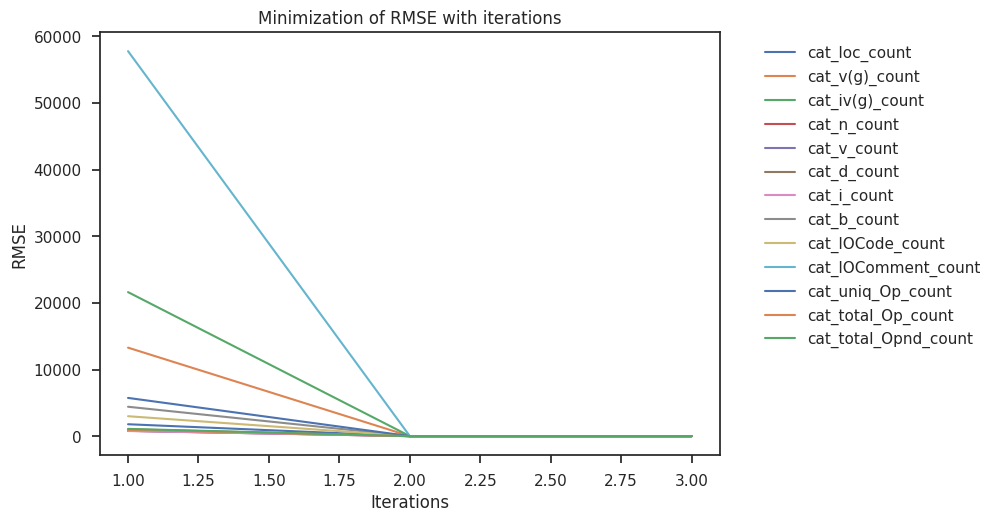

In [13]:
def high_freq_ohe(train, test, extra_cols, target):
    '''
    If you wish to apply one hot encoding on a feature with so many unique values, then this can be applied, 
    where it takes a maximum of 50 columns and drops the rest of them treating as rare categories
    '''
    train_copy=train.copy()
    test_copy=test.copy()
    ohe_cols=[]
    for col in extra_cols:
        dict1=train_copy[col].value_counts().to_dict()
        ordered=dict(sorted(dict1.items(), key=lambda x: x[1], reverse=True))
        rare_keys=list([*ordered.keys()][50:])
#         ext_keys=[f[0] for f in ordered.items() if f[1]<50]
        rare_key_map=dict(zip(rare_keys, np.full(len(rare_keys),9999)))
        
        train_copy[col]=train_copy[col].replace(rare_key_map)
        test_copy[col]=test_copy[col].replace(rare_key_map)
    train_copy, test_copy = OHE(train_copy, test_copy, extra_cols, target)
    drop_cols=[f for f in train_copy.columns if "9999" in f or train_copy[f].nunique()==1]
    train_copy=train_copy.drop(columns=drop_cols)
    test_copy=test_copy.drop(columns=drop_cols)
    
    return train_copy, test_copy

def cat_encoding(train, test,cat_cols, target):
    '''Takes in a list of features and applied different categorical encoding techniques including One-hot and return the best one using 
    a single var model and other encoders if they do not have high correlation'''
    global overall_best_score
    global overall_best_col
    table = PrettyTable()
    table.field_names = ['Feature', 'Encoded Feature', 'ROC AUC Score']
    train_copy=train.copy()
    test_copy=test.copy()
    train_dum = train.copy()
    for feature in cat_cols:
#         cat_labels = train_copy.groupby([feature])[target].mean().sort_values().index
#         cat_labels2 = {k: i for i, k in enumerate(cat_labels, 0)}
#         train_copy[feature + "_target"] = train_copy[feature].map(cat_labels2)
#         test_copy[feature + "_target"] = test_copy[feature].map(cat_labels2)

        dic = train_copy[feature].value_counts().to_dict()
        train_copy[feature + "_count"] =train_copy[feature].map(dic)
        test_copy[feature + "_count"] = test_copy[feature].map(dic)

        dic2=train_copy[feature].value_counts().to_dict()
        list1=np.arange(len(dic2.values()),0,-1) # Higher rank for high count
        # list1=np.arange(len(dic2.values())) # Higher rank for low count
        dic3=dict(zip(list(dic2.keys()),list1))
        train_copy[feature+"_count_label"]=train_copy[feature].replace(dic3).astype(float)
        test_copy[feature+"_count_label"]=test_copy[feature].replace(dic3).astype(float)

        temp_cols = [feature + "_count", feature + "_count_label"]
        if train_copy[feature].dtype=='O':
            train_copy, test_copy = OHE(train_copy, test_copy, [feature], target)
            train_copy=train_copy.drop(columns=[feature])
            test_copy=test_copy.drop(columns=[feature])
        else:
            if train_copy[feature].nunique()<50:
                train_copy[feature]=train_copy[feature].astype(str)+"_"+feature
                test_copy[feature]=test_copy[feature].astype(str)+"_"+feature
                train_copy, test_copy = OHE(train_copy, test_copy, [feature], target)
                train_copy=train_copy.drop(columns=[feature])
                test_copy=test_copy.drop(columns=[feature])
#                 temp_cols.append(feature)
            else:
                train_copy,test_copy=high_freq_ohe(train_copy,test_copy,[feature], target)
            

        kf = KFold(n_splits=5, shuffle=True, random_state=42)

        auc_scores = []

        for f in temp_cols:
            X = train_copy[[f]].values
            y = train_copy[target].astype(int).values

            auc = []
            for train_idx, val_idx in kf.split(X, y):
                X_train, y_train = X[train_idx], y[train_idx]
                x_val, y_val = X[val_idx], y[val_idx]
                model =  HistGradientBoostingClassifier (max_iter=300, learning_rate=0.02, max_depth=6, random_state=42)
                model.fit(X_train, y_train)
                y_pred = model.predict_proba(x_val)[:,1]
                auc.append(roc_auc_score(y_val,  y_pred))
            auc_scores.append((f, np.mean(auc)))
            if overall_best_score < np.mean(auc):
                overall_best_score = np.mean(auc)
                overall_best_col = f
        best_col, best_auc = sorted(auc_scores, key=lambda x: x[1], reverse=True)[0]

        corr = train_copy[temp_cols].corr(method='pearson')
        corr_with_best_col = corr[best_col]
        cols_to_drop = [f for f in temp_cols if corr_with_best_col[f] > 0.5 and f != best_col]
        final_selection = [f for f in temp_cols if f not in cols_to_drop]
        if cols_to_drop:
            train_copy = train_copy.drop(columns=cols_to_drop)
            test_copy = test_copy.drop(columns=cols_to_drop)

        table.add_row([feature, best_col, best_auc])

    print(table)
    print("overall best CV score: ", overall_best_score)
    return train_copy, test_copy

train, test= cat_encoding(train, test,selected_cols, "defects")
train, test = fill_missing_numerical(train, test,"defects",3)

# 4.3 Numerical Clustering

In [14]:
table = PrettyTable()
table.field_names = ['Clustered Feature', 'ROC AUC (CV-TRAIN)']
for col in cont_cols:
    sub_set=[f for f in unimportant_features if col in f]
    temp_train=train[sub_set]
    temp_test=test[sub_set]
    sc=StandardScaler()
    temp_train=sc.fit_transform(temp_train)
    temp_test=sc.transform(temp_test)
    model = KMeans()

    # print(ideal_clusters)
    kmeans = KMeans(n_clusters=10)
    kmeans.fit(np.array(temp_train))
    labels_train = kmeans.labels_

    train[col+"_unimp_cluster_WOE"] = labels_train
    test[col+"_unimp_cluster_WOE"] = kmeans.predict(np.array(temp_test))

    
    kf=KFold(n_splits=5, shuffle=True, random_state=42)
    
    X=train[[col+"_unimp_cluster_WOE"]].values
    y=train["defects"].astype(int).values

    auc=[]
    for train_idx, val_idx in kf.split(X,y):
        X_train,y_train=X[train_idx],y[train_idx]
        x_val,y_val=X[val_idx],y[val_idx]
        model = HistGradientBoostingClassifier(max_iter=300, learning_rate=0.02, max_depth=6, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(x_val)[:,1]
        auc.append(roc_auc_score(y_val,y_pred))
        
    table.add_row([col+"_unimp_cluster_WOE",np.mean(auc)])
    if overall_best_score<np.mean(auc):
        overall_best_score=np.mean(auc)
        overall_best_col=col+"_unimp_cluster_WOE"

print(table)
print("overall best CV score: ", overall_best_score)


+---------------------+--------------------+
|  Clustered Feature  | ROC AUC (CV-TRAIN) |
+---------------------+--------------------+
| v_unimp_cluster_WOE | 0.7467305008786567 |
| d_unimp_cluster_WOE | 0.7289213038432368 |
| i_unimp_cluster_WOE | 0.7231595576747465 |
| e_unimp_cluster_WOE | 0.6918959989225745 |
| t_unimp_cluster_WOE | 0.7462166555148542 |
+---------------------+--------------------+
overall best CV score:  0.7764308919275014


# 4.4 Arithmetic New Features

<font size="3">Until now, I have saved the best overall column and the best overall score, a few feature can be created based on the below criteria:</font>
* New features are based on the existing features by computing the arithmetic combinations
* The best arithmetic function is selected based on the individual performnace
* If the best arithmetic feature has better f1 score than the overall best score or the correlation of this feature with the existing features is less than 0.9, then a new feature is added to the dataset. 

In [15]:
def better_features(train, test, target, cols, best_score):
    new_cols = []
    skf = KFold(n_splits=5, shuffle=True, random_state=42)  # Stratified k-fold object
    best_list=[]
    for i in tqdm(range(len(cols)), desc='Generating Columns'):
        col1 = cols[i]
        temp_df = pd.DataFrame()  # Temporary dataframe to store the generated columns
        temp_df_test = pd.DataFrame()  # Temporary dataframe for test data

        for j in range(i+1, len(cols)):
            col2 = cols[j]
            # Multiply
            temp_df[col1 + '*' + col2] = train[col1] * train[col2]
            temp_df_test[col1 + '*' + col2] = test[col1] * test[col2]

            # Divide (col1 / col2)
            temp_df[col1 + '/' + col2] = train[col1] / (train[col2] + 1e-5)
            temp_df_test[col1 + '/' + col2] = test[col1] / (test[col2] + 1e-5)

            # Divide (col2 / col1)
            temp_df[col2 + '/' + col1] = train[col2] / (train[col1] + 1e-5)
            temp_df_test[col2 + '/' + col1] = test[col2] / (test[col1] + 1e-5)

            # Subtract
            temp_df[col1 + '-' + col2] = train[col1] - train[col2]
            temp_df_test[col1 + '-' + col2] = test[col1] - test[col2]

            # Add
            temp_df[col1 + '+' + col2] = train[col1] + train[col2]
            temp_df_test[col1 + '+' + col2] = test[col1] + test[col2]

        SCORES = []
        for column in temp_df.columns:
            scores = []
            for train_index, val_index in skf.split(train, train[target]):
                X_train, X_val = temp_df[column].iloc[train_index].values.reshape(-1, 1), temp_df[column].iloc[val_index].values.reshape(-1, 1)
                y_train, y_val = train[target].astype(int).iloc[train_index], train[target].astype(int).iloc[val_index]
                model = LogisticRegression()#HistGradientBoostingClassifier(max_iter=300, learning_rate=0.02, max_depth=6, random_state=42)
                model.fit(X_train, y_train)
                y_pred = model.predict_proba(X_val)[:,1]
                score = roc_auc_score( y_val, y_pred)
                scores.append(score)
            mean_score = np.mean(scores)
            SCORES.append((column, mean_score))

        if SCORES:
            best_col, best_auc = sorted(SCORES, key=lambda x: x[1],reverse=True)[0]
            corr_with_other_cols = train.drop([target] + new_cols, axis=1).corrwith(temp_df[best_col])
            if (corr_with_other_cols.abs().max() < 0.9 or best_auc > best_score) and corr_with_other_cols.abs().max() !=1 :
                train[best_col] = temp_df[best_col]
                test[best_col] = temp_df_test[best_col]
                new_cols.append(best_col)
                print(f"Added column '{best_col}' with ROC AUC Score: {best_auc:.4f} & Correlation {corr_with_other_cols.abs().max():.4f}")

    return train, test, new_cols

In [ ]:
selected_features=[f for f in train.columns if train[f].nunique()>2 and f not in unimportant_features]
train, test,new_cols=better_features(train, test, 'defects', selected_features, overall_best_score)

Generating Columns:   1%|▏         | 1/69 [06:45<7:39:36, 405.53s/it]

Added column 'loc-cat_lOBlank_count_label' with ROC AUC Score: 0.7770 & Correlation 0.9973


Generating Columns:  25%|██▍       | 17/69 [1:44:41<4:49:51, 334.45s/it]

<font size="3">We don't have to run the above algorithm every time, just run it once to store the combinations and compute just the required columns</font>

In [ ]:
new_cols=['loc-lOBlank_count_label',
 'b_count-total_Op_count',
 'lOCode_count-total_Op_count',
 'd_unimp_cluster_WOE*e_unimp_cluster_WOE',
 'iv(g)_count*b_count',
 'd_unimp_cluster_WOE/e_unimp_cluster_WOE',
 'l/n',
 'd-b_target',
 'v(g)_count_label/b_target',
 'iv(g)+b_target',
 'ev(g)_count/b_target',
 'v(g)+b_target',
 'l_count/uniq_Op_count',
 'locCodeAndComment_count/e_unimp_cluster_WOE',
 'branchCount+b_target',
 'i-b_target',
 'l_target*b_target',
 'i_unimp_cluster_WOE-e_unimp_cluster_WOE',
 'e_unimp_cluster_WOE*t_unimp_cluster_WOE',
 'i_unimp_cluster_WOE*e_unimp_cluster_WOE',
 'ev(g)_target+b_target',
 'y_J_v-b_target',
 'loc+lOBlank',
 'v_unimp_cluster_WOE*e_unimp_cluster_WOE',
 'total_Op_count/e_unimp_cluster_WOE',
 'e-b_target',
 't-b_target',
 'v(g)_count/b_target',
 'ev(g)_count_label*lOBlank_count_label',
 'b_count/e_unimp_cluster_WOE',
 'v(g)_count*b_count',
 'ev(g)_count_label/b_target',
 'locCodeAndComment_target+e_unimp_cluster_WOE',
 'uniq_Op_count-total_Op_count',
 'total_Opnd_count/e_unimp_cluster_WOE',
 'v(g)_target+b_target',
 'n_count-b_count',
 'lOBlank+b_target',
 'l-b_target',
 'b_target-lOComment_count_label',
 'ev(g)+b_target',
 'lOComment_count/e_unimp_cluster_WOE',
 'lOComment+b_target']

In [ ]:
def apply_arithmetic_operations(train_df, test_df, expressions_list):
    '''
    We pass the selected arithmetic combinations
    '''
    for expression in expressions_list:
        if expression not in train_df.columns:
            # Split the expression based on operators (+, -, *, /)
            parts = expression.split('+') if '+' in expression else \
                    expression.split('-') if '-' in expression else \
                    expression.split('*') if '*' in expression else \
                    expression.split('/')

            # Get the DataFrame column names involved in the operation
            cols = [col for col in parts]

            # Perform the corresponding arithmetic operation based on the operator in the expression
            if cols[0] in train_df.columns and cols[1] in train_df.columns:
                if '+' in expression:
                    train_df[expression] = train_df[cols[0]] + train_df[cols[1]]
                    test_df[expression] = test_df[cols[0]] + test_df[cols[1]]
                elif '-' in expression:
                    train_df[expression] = train_df[cols[0]] - train_df[cols[1]]
                    test_df[expression] = test_df[cols[0]] - test_df[cols[1]]
                elif '*' in expression:
                    train_df[expression] = train_df[cols[0]] * train_df[cols[1]]
                    test_df[expression] = test_df[cols[0]] * test_df[cols[1]]
                elif '/' in expression:
                    train_df[expression] = train_df[cols[0]] / (train_df[cols[1]]+1e-5)
                    test_df[expression] = test_df[cols[0]] /( test_df[cols[1]]+1e-5)
    
    return train_df, test_df

train, test = apply_arithmetic_operations(train, test, new_cols)

# 4.5 Feature Elimination

In [ ]:
first_drop=[ f for f in unimportant_features if f in train.columns]
train=train.drop(columns=first_drop)
test=test.drop(columns=first_drop)

In [ ]:
final_drop_list=[]

table = PrettyTable()
table.field_names = ['Original', 'Final Transformation', 'ROV AUC CV']
threshold=0.95
# It is possible that multiple parent features share same child features, so store selected features to avoid selecting the same feature again
best_cols=[]

for col in cont_cols:
    sub_set=[f for f in train.columns if (str(col) in str(f)) and (train[f].nunique()>2)]
#     print(sub_set)
    if len(sub_set)>2:
        correlated_features = []

        for i, feature in enumerate(sub_set):
            # Check correlation with all remaining features
            for j in range(i+1, len(sub_set)):
                correlation = np.abs(train[feature].corr(train[sub_set[j]]))
                # If correlation is greater than threshold, add to list of highly correlated features
                if correlation > threshold:
                    correlated_features.append(sub_set[j])

        # Remove duplicate features from the list
        correlated_features = list(set(correlated_features))
#         print(correlated_features)
        if len(correlated_features)>=2:

            temp_train=train[correlated_features]
            temp_test=test[correlated_features]
            #Scale before applying PCA
            sc=StandardScaler()
            temp_train=sc.fit_transform(temp_train)
            temp_test=sc.transform(temp_test)

            # Initiate PCA
            pca=TruncatedSVD(n_components=1)
            x_pca_train=pca.fit_transform(temp_train)
            x_pca_test=pca.transform(temp_test)
            x_pca_train=pd.DataFrame(x_pca_train, columns=[col+"_pca_comb_final"])
            x_pca_test=pd.DataFrame(x_pca_test, columns=[col+"_pca_comb_final"])
            train=pd.concat([train,x_pca_train],axis='columns')
            test=pd.concat([test,x_pca_test],axis='columns')

            # Clustering
            model = KMeans()
            kmeans = KMeans(n_clusters=10)
            kmeans.fit(np.array(temp_train))
            labels_train = kmeans.labels_

            train[col+'_final_cluster'] = labels_train
            test[col+'_final_cluster'] = kmeans.predict(np.array(temp_test))


            correlated_features=correlated_features+[col+"_pca_comb_final",col+"_final_cluster"]

            # See which transformation along with the original is giving you the best univariate fit with target
            kf=KFold(n_splits=5, shuffle=True, random_state=42)

            scores=[]

            for f in correlated_features:
                X=train[[f]].values
                y=train["defects"].astype(int).values

                auc=[]
                for train_idx, val_idx in kf.split(X,y):
                    X_train,y_train=X[train_idx],y[train_idx]
                    X_val,y_val=X[val_idx],y[val_idx]

                    model = HistGradientBoostingClassifier (max_iter=300, learning_rate=0.02, max_depth=6, random_state=42)
                    model.fit(X_train,y_train)
                    y_pred = model.predict_proba(X_val)[:,1]
                    score = roc_auc_score( y_val, y_pred)
                    auc.append(score)
                if f not in best_cols:
                    scores.append((f,np.mean(auc)))
            best_col, best_auc=sorted(scores, key=lambda x:x[1], reverse=True)[0]
            best_cols.append(best_col)

            cols_to_drop = [f for f in correlated_features if  f not in best_cols]
            if cols_to_drop:
                final_drop_list=final_drop_list+cols_to_drop
            table.add_row([col,best_col ,best_auc])

print(table)      

# 5. FEATURE SELECTION

In [ ]:
final_features=[f for f in train.columns if f not in ['defects']]
final_features=[*set(final_features)]

sc=StandardScaler()

train_scaled=train.copy()
test_scaled=test.copy()
train_scaled[final_features]=sc.fit_transform(train[final_features])
test_scaled[final_features]=sc.transform(test[final_features])

In [ ]:
def post_processor(train, test):
    '''
    After Scaleing, some of the features may be the same and can be eliminated
    '''
    cols=[f for f in train.columns if "defects" not in f and "OHE" not in f]
    train_cop=train.copy()
    test_cop=test.copy()
    drop_cols=[]
    for i, feature in enumerate(cols):
        for j in range(i+1, len(cols)):
            if sum(abs(train_cop[feature]-train_cop[cols[j]]))==0:
                if cols[j] not in drop_cols:
                    drop_cols.append(cols[j])
    print(drop_cols)
    train_cop.drop(columns=drop_cols,inplace=True)
    test_cop.drop(columns=drop_cols,inplace=True)
    
    return train_cop, test_cop

                    
train_cop, test_cop=   post_processor(train_scaled, test_scaled)            

In [ ]:
X_train = train_cop.drop(columns=['defects'])
y_train = train['defects'].astype(int)

X_test = test_cop.copy()

print(X_train.shape, X_test.shape)

In [ ]:
def get_most_important_features(X_train, y_train, n,model_input):
    xgb_params = {
            'n_jobs': -1,
            'eval_metric': 'logloss',
            'objective': 'binary:logistic',
            'tree_method': 'hist',
            'verbosity': 0,
            'random_state': 42,
        }
    lgb_params = {
            'objective': 'binary',
            'metric': 'logloss',
            'boosting_type': 'gbdt',
            'random_state': 42,
        }
    cb_params = {
            'grow_policy': 'Depthwise',
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            'eval_metric': 'AUC',
            'loss_function': 'Logloss',
            'random_state': 42,
        }
    if 'xgb' in model_input:
        model = xgb.XGBClassifier(**xgb_params)
    elif 'cat' in model_input:
        model=CatBoostClassifier(**cb_params)
    else:
        model=lgb.LGBMClassifier(**lgb_params)
        
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []
    feature_importances_list = []
    
    for train_idx, val_idx in kfold.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold, verbose=False)
        
        y_pred = model.predict_proba(X_val_fold)[:,1]
        auc_scores.append(roc_auc_score(y_val_fold, y_pred))
        feature_importances = model.feature_importances_
        feature_importances_list.append(feature_importances)

    avg_auc= np.mean(auc_scores)
    avg_feature_importances = np.mean(feature_importances_list, axis=0)

    feature_importance_list = [(X_train.columns[i], importance) for i, importance in enumerate(avg_feature_importances)]
    sorted_features = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)
    top_n_features = [feature[0] for feature in sorted_features[:n]]

    display_features=top_n_features[:10]
    
    sns.set_palette("Set2")
    plt.figure(figsize=(8, 6))
    plt.barh(range(len(display_features)), [avg_feature_importances[X_train.columns.get_loc(feature)] for feature in display_features])
    plt.yticks(range(len(display_features)), display_features, fontsize=12)
    plt.xlabel('Average Feature Importance', fontsize=14)
    plt.ylabel('Features', fontsize=10)
    plt.title(f'Top {10} of {n} Feature Importances with ROC AUC score {avg_auc}', fontsize=16)
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    # Add data labels on the bars
    for index, value in enumerate([avg_feature_importances[X_train.columns.get_loc(feature)] for feature in display_features]):
        plt.text(value + 0.005, index, f'{value:.3f}', fontsize=12, va='center')

    plt.tight_layout()
    plt.show()

    return top_n_features


In [ ]:
n_imp_features_cat=get_most_important_features(X_train.reset_index(drop=True), y_train,500, 'cat')
n_imp_features_xgb=get_most_important_features(X_train.reset_index(drop=True), y_train,500, 'xgb')
n_imp_features_lgbm=get_most_important_features(X_train.reset_index(drop=True), y_train,500, 'lgbm')

In [ ]:
n_imp_features=[*set(n_imp_features_xgb+n_imp_features_lgbm+n_imp_features_cat)]
print(f"{len(n_imp_features)} features have been selected from three algorithms for the final model")

In [ ]:
X_train=X_train[n_imp_features]
X_test=X_test[n_imp_features]

# 6. MODELING

## 6.1 Class Weights

In [ ]:
classes = np.unique(y_train)  
class_to_index = {cls: idx for idx, cls in enumerate(classes)}
y_train_numeric = np.array([class_to_index[cls] for cls in y_train])

class_counts = np.bincount(y_train_numeric)

total_samples = len(y_train_numeric)

class_weights = total_samples / (len(classes) * class_counts)

class_weights_dict = {cls: weight for cls, weight in zip(classes, class_weights)}

print("Class counts:", class_counts)
print("Total samples:", total_samples)
print("Class weights:", class_weights)
print("Class weights dictionary:", class_weights_dict)

## 6.2 Models

In [ ]:
class Splitter:
    def __init__(self, test_size=0.2, kfold=True, n_splits=5):
        self.test_size = test_size
        self.kfold = kfold
        self.n_splits = n_splits

    def split_data(self, X, y, random_state_list):
        if self.kfold:
            for random_state in random_state_list:
                kf = KFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(X, y):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val

class Classifier:
    def __init__(self, n_estimators=100, device="cpu", random_state=0):
        self.n_estimators = n_estimators
        self.device = device
        self.random_state = random_state
        self.models = self._define_model()
        self.len_models = len(self.models)
        
    def _define_model(self):
        xgb_params = {
            'n_estimators': self.n_estimators,
            'learning_rate': 0.1,
            'max_depth': 4,
            'subsample': 0.8,
            'colsample_bytree': 0.1,
            'n_jobs': -1,
            'eval_metric': 'logloss',
            'objective': 'binary:logistic',
            'tree_method': 'hist',
            'verbosity': 0,
            'random_state': self.random_state,
#             'class_weight':class_weights_dict,
        }
        if self.device == 'gpu':
            xgb_params['tree_method'] = 'gpu_hist'
            xgb_params['predictor'] = 'gpu_predictor'
            
        xgb_params2=xgb_params.copy() 
        xgb_params2['subsample']= 0.3
        xgb_params2['max_depth']=8
        xgb_params2['learning_rate']=0.005
        xgb_params2['colsample_bytree']=0.9

        xgb_params3=xgb_params.copy() 
        xgb_params3['subsample']= 0.6
        xgb_params3['max_depth']=6
        xgb_params3['learning_rate']=0.02
        xgb_params3['colsample_bytree']=0.7      
        
        lgb_params = {
            'n_estimators': self.n_estimators,
            'max_depth': 8,
            'learning_rate': 0.02,
            'subsample': 0.20,
            'colsample_bytree': 0.56,
            'reg_alpha': 0.25,
            'reg_lambda': 5e-08,
            'objective': 'binary',
            'boosting_type': 'gbdt',
            'device': self.device,
            'random_state': self.random_state,
            'class_weight':class_weights_dict,
        }
        lgb_params2 = {
            'n_estimators': self.n_estimators,
            'max_depth': 6,
            'learning_rate': 0.05,
            'subsample': 0.20,
            'colsample_bytree': 0.56,
            'reg_alpha': 0.25,
            'reg_lambda': 5e-08,
            'objective': 'binary',
            'boosting_type': 'gbdt',
            'device': self.device,
            'random_state': self.random_state,
        }
        lgb_params3=lgb_params.copy()  
        lgb_params3['subsample']=0.9
        lgb_params3['reg_lambda']=0.3461495211744402
        lgb_params3['reg_alpha']=0.3095626288582237
        lgb_params3['max_depth']=8
        lgb_params3['learning_rate']=0.007
        lgb_params3['colsample_bytree']=0.5

        lgb_params4=lgb_params2.copy()  
        lgb_params4['subsample']=0.7
        lgb_params4['reg_lambda']=0.1
        lgb_params4['reg_alpha']=0.2
        lgb_params4['max_depth']=10
        lgb_params4['learning_rate']=0.007
        lgb_params4['colsample_bytree']=0.5
        cb_params = {
            'iterations': self.n_estimators,
            'depth': 6,
            'learning_rate': 0.1,
            'l2_leaf_reg': 0.7,
            'random_strength': 0.2,
            'max_bin': 200,
            'od_wait': 65,
            'one_hot_max_size': 120,
            'grow_policy': 'Depthwise',
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            'eval_metric': 'AUC',
            'loss_function': 'Logloss',
            'task_type': self.device.upper(),
            'random_state': self.random_state,
        }
        cb_sym_params = cb_params.copy()
        cb_sym_params['grow_policy'] = 'SymmetricTree'
        cb_loss_params = cb_params.copy()
        cb_loss_params['grow_policy'] = 'Lossguide'
        
        cb_params2=  cb_params.copy()
        cb_params2['learning_rate']=0.01
        cb_params2['depth']=8
        
        cb_params3={
            'iterations': self.n_estimators,
            'random_strength': 0.1, 
            'one_hot_max_size': 70, 
            'max_bin': 100, 
            'learning_rate': 0.008, 
            'l2_leaf_reg': 0.3, 
            'grow_policy': 'Depthwise', 
            'depth': 10, 
            'max_bin': 200,
            'od_wait': 65,
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            'eval_metric': 'AUC',
            'loss_function': 'Logloss',
            'task_type': self.device.upper(),
            'random_state': self.random_state,
        }
        cb_params4=  cb_params.copy()
        cb_params4['learning_rate']=0.01
        cb_params4['depth']=12
        dt_params= {'min_samples_split': 30, 'min_samples_leaf': 10, 'max_depth': 8, 'criterion': 'gini'}
        
        models = {
            'xgb': xgb.XGBClassifier(**xgb_params),
            'xgb2': xgb.XGBClassifier(**xgb_params2),
            'xgb3': xgb.XGBClassifier(**xgb_params3),
            'lgb': lgb.LGBMClassifier(**lgb_params),
            'lgb2': lgb.LGBMClassifier(**lgb_params2),
            'lgb3': lgb.LGBMClassifier(**lgb_params3),
            'lgb4': lgb.LGBMClassifier(**lgb_params4),
            'cat': CatBoostClassifier(**cb_params),
            'cat2': CatBoostClassifier(**cb_params2),
            'cat3': CatBoostClassifier(**cb_params2),
            'cat4': CatBoostClassifier(**cb_params2),
            "cat_sym": CatBoostClassifier(**cb_sym_params),
            "cat_loss": CatBoostClassifier(**cb_loss_params),
            'hist_gbm' : HistGradientBoostingClassifier (max_iter=300, learning_rate=0.001,  max_leaf_nodes=80,
                                                         max_depth=6,class_weight=class_weights_dict, random_state=self.random_state),
#             'gbdt': GradientBoostingClassifier(max_depth=6,  n_estimators=1000,random_state=self.random_state),
            'lr': LogisticRegression(),
            'rf': RandomForestClassifier(max_depth= 9,max_features= 'auto',min_samples_split= 10,
                                                          min_samples_leaf= 4,  n_estimators=500,random_state=self.random_state),
#             'svc': SVC(gamma="auto", probability=True),
#             'knn': KNeighborsClassifier(n_neighbors=5),
#             'mlp': MLPClassifier(random_state=self.random_state, max_iter=1000),
#              'etr':ExtraTreesClassifier(min_samples_split=55, min_samples_leaf= 15, max_depth=10,
#                                        n_estimators=200,random_state=self.random_state),
#             'dt' :DecisionTreeClassifier(**dt_params,random_state=self.random_state),
#             'ada': AdaBoostClassifier(random_state=self.random_state),
                                       
        }
        return models

## 6.3 Optimize Ensemble Weights

In [ ]:
class OptunaWeights:
    def __init__(self, random_state, n_trials=2000):
        self.study = None
        self.weights = None
        self.random_state = random_state
        self.n_trials = n_trials

    def _objective(self, trial, y_true, y_preds):
        # Define the weights for the predictions from each model
        weights = [trial.suggest_float(f"weight{n}", -1, 2) for n in range(len(y_preds))]

        # Calculate the weighted prediction
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=weights)

        auc_score = roc_auc_score(y_true, weighted_pred)
        log_loss_score=log_loss(y_true, weighted_pred)
        return auc_score/log_loss_score

    def fit(self, y_true, y_preds):
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        pruner = optuna.pruners.HyperbandPruner()
        self.study = optuna.create_study(sampler=sampler, pruner=pruner, study_name="OptunaWeights", direction='maximize')
        objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
        self.study.optimize(objective_partial, n_trials=self.n_trials)
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=self.weights)
        return weighted_pred

    def fit_predict(self, y_true, y_preds):
        self.fit(y_true, y_preds)
        return self.predict(y_preds)
    
    def weights(self):
        return self.weights

## 6.4 Model Fit

In [ ]:
kfold = True
n_splits = 1 if not kfold else 10
random_state = 2023
random_state_list = [42] # used by split_data [71]
n_estimators = 9999 # 9999
early_stopping_rounds = 300
verbose = False
device = 'cpu'

splitter = Splitter(kfold=kfold, n_splits=n_splits)

# Initialize an array for storing test predictions
test_predss = np.zeros(X_test.shape[0])
ensemble_score = []
weights = []
trained_models = {'xgb':[], 'lgb':[], 'cat':[]}

    
for i, (X_train_, X_val, y_train_, y_val) in enumerate(splitter.split_data(X_train, y_train, random_state_list=random_state_list)):
    n = i % n_splits
    m = i // n_splits
            
    # Get a set of Regressor models
    classifier = Classifier(n_estimators, device, random_state)
    models = classifier.models
    
    # Initialize lists to store oof and test predictions for each base model
    oof_preds = []
    test_preds = []
    
    # Loop over each base model and fit it to the training data, evaluate on validation data, and store predictions
    for name, model in models.items():
        if ('cat' in name) or ("lgb" in name) or ("xgb" in name):
            if 'lgb' == name: #categorical_feature=cat_features
                model.fit(X_train_, y_train_, eval_set=[(X_val, y_val)],#,categorical_feature=cat_features,
                          early_stopping_rounds=early_stopping_rounds, verbose=verbose)
            elif 'cat' ==name:
                model.fit(X_train_, y_train_, eval_set=[(X_val, y_val)],#cat_features=cat_features,
                          early_stopping_rounds=early_stopping_rounds, verbose=verbose)
            else:
                model.fit(X_train_, y_train_, eval_set=[(X_val, y_val)], early_stopping_rounds=early_stopping_rounds, verbose=verbose)
        elif name in 'ann':
            model.fit(X_train_, y_train_, validation_data=(X_val, y_val),batch_size=5, epochs=50,verbose=verbose)
        else:
            model.fit(X_train_, y_train_)
        
        if name in 'ann':
            test_pred = np.array(model.predict(X_test))[:, 0]
            y_val_pred = np.array(model.predict(X_val))[:, 0]
        else:
            test_pred = model.predict_proba(X_test)[:, 1]
            y_val_pred = model.predict_proba(X_val)[:, 1]

        score = roc_auc_score(y_val, y_val_pred)
#         score = accuracy_score(y_val, acc_cutoff_class(y_val, y_val_pred))

        print(f'{name} [FOLD-{n} SEED-{random_state_list[m]}] ROC AUC score: {score:.5f}')
        
        oof_preds.append(y_val_pred)
        test_preds.append(test_pred)
        
        if name in trained_models.keys():
            trained_models[f'{name}'].append(deepcopy(model))
    # Use Optuna to find the best ensemble weights
    optweights = OptunaWeights(random_state=random_state)
    y_val_pred = optweights.fit_predict(y_val.values, oof_preds)
    
    score = roc_auc_score(y_val, y_val_pred)
#     score = accuracy_score(y_val, acc_cutoff_class(y_val, y_val_pred))
    print(f'Ensemble [FOLD-{n} SEED-{random_state_list[m]}] ------------------>  ROC AUC score {score:.5f}')
    ensemble_score.append(score)
    weights.append(optweights.weights)
    
    test_predss += optweights.predict(test_preds) / (n_splits * len(random_state_list))
    
    gc.collect()

In [ ]:
# Calculate the mean LogLoss score of the ensemble
mean_score = np.mean(ensemble_score)
std_score = np.std(ensemble_score)
print(f'Ensemble ROC AUC score {mean_score:.5f} ± {std_score:.5f}')

# Print the mean and standard deviation of the ensemble weights for each model
print('--- Model Weights ---')
mean_weights = np.mean(weights, axis=0)
std_weights = np.std(weights, axis=0)
for name, mean_weight, std_weight in zip(models.keys(), mean_weights, std_weights):
    print(f'{name}: {mean_weight:.5f} ± {std_weight:.5f}')

## 6.5 Feature Importance Visualization

In [ ]:
def visualize_importance(models, feature_cols, title, head=15):
    importances = []
    feature_importance = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["importance"] = model.feature_importances_
        _df["feature"] = pd.Series(feature_cols)
        _df["fold"] = i
        _df = _df.sort_values('importance', ascending=False)
        _df = _df.head(head)
        feature_importance = pd.concat([feature_importance, _df], axis=0, ignore_index=True)
        
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    # display(feature_importance.groupby(["feature"]).mean().reset_index().drop('fold', axis=1))
    plt.figure(figsize=(18, 10))
    sns.barplot(x='importance', y='feature', data=feature_importance, color= (0.4, 0.76, 0.65), errorbar='sd')
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.title(f'{title} Feature Importance', fontsize=18)
    plt.grid(True, axis='x')
    plt.show()
    
for name, models in trained_models.items():
    visualize_importance(models, list(X_train.columns), name)

## 6.6 Submission

In [ ]:
sub = pd.read_csv('/kaggle/input/playground-series-s3e23/sample_submission.csv')
sub['defects'] =  test_predss
sub.to_csv('submission_pure.csv',index=False)
sub.head()

## 6.7 Ensemble- Averaging

<font size="3">Let's also takes the best notebooks at the topcompute porbabilistice averages after scaling.</font>
* Notebook by [@ravi20076](https://www.kaggle.com/code/ravi20076/playgrounds3e23-eda-baseline)
* Notebook by [@oscarm524](https://www.kaggle.com/code/oscarm524/ps-s3-ep23-eda-modeling-submission)
* Notebook by [@francescoliveras](https://www.kaggle.com/code/francescoliveras/ps-s3-e23-eda-model-en-es)

In [ ]:
sub1=pd.read_csv("/kaggle/input/playgrounds3e23-eda-baseline/Submission_V3.csv")
sub2=pd.read_csv("/kaggle/input/ps-s3-ep23-eda-modeling-submission/Hill_Ensemble_Baseline_submission_25_folds.csv")
sub3=pd.read_csv("/kaggle/input/ps-s3-e23-eda-model-en-es/submission.csv")

In [ ]:
sub_combined=sub1.copy()

sub1['defects']=(sub1['defects']-sub1['defects'].min())/(sub1['defects'].max()-sub1['defects'].min())
sub2['defects']=(sub2['defects']-sub2['defects'].min())/(sub2['defects'].max()-sub2['defects'].min())
sub3['defects']=(sub3['defects']-sub3['defects'].min())/(sub3['defects'].max()-sub3['defects'].min())

sub_combined['defects']=(sub1['defects'] + sub2['defects'] +sub3['defects'] +sub["defects"])/4

In [ ]:
sub_combined.to_csv('submission.csv',index=False)